In [1]:
!nvidia-smi

Fri Mar  1 01:17:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   38C    P8              20W / 215W |    518MiB /  8192MiB |      7%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
sr = 16000
data_dir = '../data/data_preprocessed/iemocap/preprocessing/'
data_x = np.load(f'{data_dir}iemocap.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}iemocap.label4.npy', allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3948
Test: 988


In [8]:
y_train[0]

'ang'

In [9]:
np.unique(y_train)

array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

In [11]:
def label_to_index(word):
    return labels.index(word)
label_to_index(y_train[0])

0

In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
import traceback

In [15]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 40, 'n_fft': 512, 'hop_length': 128, 'n_mels': 64, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006514657980456026/10 [00:00<12:08, 72.86s/it]

Train Epoch: 1 [0/3948 (0%)]	Loss: 1.178210
Mem before-during-after: 1226752 9887232 21712384


  1%|▍                                  | 0.13680781758957658/10 [00:07<08:20, 50.76s/it]

Train Epoch: 1 [640/3948 (16%)]	Loss: 1.187883
Mem before-during-after: 21712384 21852160 21712384


  3%|▉                                  | 0.26710097719869713/10 [00:13<08:11, 50.53s/it]

Train Epoch: 1 [1280/3948 (33%)]	Loss: 1.373536
Mem before-during-after: 21712384 21852160 21712384


  4%|█▍                                  | 0.3973941368078177/10 [00:20<08:19, 52.04s/it]

Train Epoch: 1 [1920/3948 (49%)]	Loss: 1.320008
Mem before-during-after: 21712384 21852160 21712384


  5%|█▉                                  | 0.5276872964169382/10 [00:27<07:49, 49.57s/it]

Train Epoch: 1 [2560/3948 (65%)]	Loss: 1.476940
Mem before-during-after: 21712384 21852160 21712384


  7%|██▎                                 | 0.6579804560260588/10 [00:34<07:52, 50.54s/it]

Train Epoch: 1 [3200/3948 (81%)]	Loss: 1.537549
Mem before-during-after: 21712384 21852160 21712384


  8%|██▊                                 | 0.7882736156351794/10 [00:40<07:41, 50.13s/it]

Train Epoch: 1 [3840/3948 (98%)]	Loss: 1.312849
Mem before-during-after: 21712384 21852160 21712384


 10%|███▌                                | 1.0032573289902282/10 [00:51<07:33, 50.39s/it]


Test Epoch: 1	Accuracy: 435/976 (44%)

Train Epoch: 2 [0/3948 (0%)]	Loss: 1.224359
Mem before-during-after: 21711360 21852160 21712384


 11%|████                                | 1.1368078175895768/10 [00:58<07:16, 49.29s/it]

Train Epoch: 2 [640/3948 (16%)]	Loss: 1.318439
Mem before-during-after: 21712384 21852160 21712384


 13%|████▌                               | 1.2671009771986974/10 [01:04<07:33, 51.88s/it]

Train Epoch: 2 [1280/3948 (33%)]	Loss: 1.205987
Mem before-during-after: 21712384 21852160 21712384


 14%|█████▏                               | 1.397394136807818/10 [01:11<07:15, 50.60s/it]

Train Epoch: 2 [1920/3948 (49%)]	Loss: 1.232031
Mem before-during-after: 21712384 21852160 21712384


 15%|█████▍                              | 1.5276872964169386/10 [01:18<07:22, 52.19s/it]

Train Epoch: 2 [2560/3948 (65%)]	Loss: 1.171088
Mem before-during-after: 21712384 21852160 21712384


 17%|█████▉                              | 1.6579804560260591/10 [01:24<07:03, 50.80s/it]

Train Epoch: 2 [3200/3948 (81%)]	Loss: 1.090073
Mem before-during-after: 21712384 21852160 21712384


 18%|██████▍                             | 1.7882736156351797/10 [01:31<06:51, 50.07s/it]

Train Epoch: 2 [3840/3948 (98%)]	Loss: 1.134978
Mem before-during-after: 21712384 21852160 21712384


 20%|███████▏                            | 2.0032573289902285/10 [01:42<06:44, 50.55s/it]


Test Epoch: 2	Accuracy: 491/976 (50%)

Train Epoch: 3 [0/3948 (0%)]	Loss: 0.999369
Mem before-during-after: 21711360 21852160 21712384


 21%|███████▉                             | 2.136807817589577/10 [01:49<06:33, 50.09s/it]

Train Epoch: 3 [640/3948 (16%)]	Loss: 1.240690
Mem before-during-after: 21712384 21852160 21712384


 23%|████████▏                           | 2.2671009771986976/10 [01:55<06:32, 50.78s/it]

Train Epoch: 3 [1280/3948 (33%)]	Loss: 1.533606
Mem before-during-after: 21712384 21852160 21712384


 24%|████████▊                            | 2.397394136807818/10 [02:02<06:43, 53.07s/it]

Train Epoch: 3 [1920/3948 (49%)]	Loss: 0.869176
Mem before-during-after: 21712384 21852160 21712384


 25%|█████████▎                           | 2.527687296416939/10 [02:09<06:23, 51.37s/it]

Train Epoch: 3 [2560/3948 (65%)]	Loss: 0.929133
Mem before-during-after: 21712384 21852160 21712384


 27%|█████████▌                          | 2.6579804560260594/10 [02:15<06:01, 49.22s/it]

Train Epoch: 3 [3200/3948 (81%)]	Loss: 0.886281
Mem before-during-after: 21712384 21852160 21712384


 28%|██████████▌                           | 2.78827361563518/10 [02:22<06:04, 50.59s/it]

Train Epoch: 3 [3840/3948 (98%)]	Loss: 1.080995
Mem before-during-after: 21712384 21852160 21712384


 30%|███████████                          | 3.003257328990229/10 [02:33<06:07, 52.54s/it]


Test Epoch: 3	Accuracy: 499/976 (51%)

Train Epoch: 4 [0/3948 (0%)]	Loss: 1.096784
Mem before-during-after: 21711360 21852160 21712384


 31%|███████████▎                        | 3.1368078175895775/10 [02:40<05:40, 49.61s/it]

Train Epoch: 4 [640/3948 (16%)]	Loss: 1.244004
Mem before-during-after: 21712384 21852160 21712384


 33%|████████████                         | 3.267100977198698/10 [02:46<05:34, 49.63s/it]

Train Epoch: 4 [1280/3948 (33%)]	Loss: 1.136379
Mem before-during-after: 21712384 21852160 21712384


 34%|████████████▏                       | 3.3973941368078187/10 [02:53<05:29, 49.86s/it]

Train Epoch: 4 [1920/3948 (49%)]	Loss: 1.197770
Mem before-during-after: 21712384 21852160 21712384


 35%|████████████▋                       | 3.5276872964169392/10 [03:00<05:17, 48.98s/it]

Train Epoch: 4 [2560/3948 (65%)]	Loss: 1.244359
Mem before-during-after: 21712384 21852160 21712384


 37%|█████████████▉                        | 3.65798045602606/10 [03:06<05:15, 49.74s/it]

Train Epoch: 4 [3200/3948 (81%)]	Loss: 1.051274
Mem before-during-after: 21712384 21852160 21712384


 38%|█████████████▋                      | 3.7882736156351804/10 [03:13<05:20, 51.63s/it]

Train Epoch: 4 [3840/3948 (98%)]	Loss: 1.337166
Mem before-during-after: 21712384 21852160 21712384


 40%|██████████████▍                     | 4.0032573289902285/10 [03:24<05:06, 51.09s/it]


Test Epoch: 4	Accuracy: 461/976 (47%)

Train Epoch: 5 [0/3948 (0%)]	Loss: 1.158941
Mem before-during-after: 21711360 21852160 21712384


 41%|███████████████▎                     | 4.136807817589559/10 [03:31<04:55, 50.42s/it]

Train Epoch: 5 [640/3948 (16%)]	Loss: 1.160583
Mem before-during-after: 21712384 21852160 21712384


 43%|███████████████▊                     | 4.267100977198662/10 [03:37<04:39, 48.69s/it]

Train Epoch: 5 [1280/3948 (33%)]	Loss: 0.836515
Mem before-during-after: 21712384 21852160 21712384


 44%|███████████████▊                    | 4.3973941368077645/10 [03:44<04:47, 51.30s/it]

Train Epoch: 5 [1920/3948 (49%)]	Loss: 1.137577
Mem before-during-after: 21712384 21852160 21712384


 45%|████████████████▊                    | 4.527687296416867/10 [03:51<04:39, 51.16s/it]

Train Epoch: 5 [2560/3948 (65%)]	Loss: 1.028182
Mem before-during-after: 21712384 21852160 21712384


 47%|█████████████████▋                    | 4.65798045602597/10 [03:57<04:28, 50.30s/it]

Train Epoch: 5 [3200/3948 (81%)]	Loss: 0.972041
Mem before-during-after: 21712384 21852160 21712384


 48%|█████████████████▋                   | 4.788273615635073/10 [04:04<04:20, 49.95s/it]

Train Epoch: 5 [3840/3948 (98%)]	Loss: 1.072523
Mem before-during-after: 21712384 21852160 21712384


 50%|██████████████████▌                  | 5.003257328990093/10 [04:15<04:12, 50.60s/it]


Test Epoch: 5	Accuracy: 481/976 (49%)

Train Epoch: 6 [0/3948 (0%)]	Loss: 1.369838
Mem before-during-after: 21711360 21852160 21712384


 51%|███████████████████                  | 5.136807817589423/10 [04:22<04:17, 53.02s/it]

Train Epoch: 6 [640/3948 (16%)]	Loss: 0.821580
Mem before-during-after: 21712384 21852160 21712384


 53%|███████████████████▍                 | 5.267100977198526/10 [04:28<03:58, 50.31s/it]

Train Epoch: 6 [1280/3948 (33%)]	Loss: 0.839572
Mem before-during-after: 21712384 21852160 21712384


 54%|███████████████████▉                 | 5.397394136807629/10 [04:35<03:52, 50.46s/it]

Train Epoch: 6 [1920/3948 (49%)]	Loss: 1.117222
Mem before-during-after: 21712384 21852160 21712384


 55%|████████████████████▍                | 5.527687296416731/10 [04:42<03:44, 50.28s/it]

Train Epoch: 6 [2560/3948 (65%)]	Loss: 0.985869
Mem before-during-after: 21712384 21852160 21712384


 57%|████████████████████▉                | 5.657980456025834/10 [04:48<04:22, 60.43s/it]

Train Epoch: 6 [3200/3948 (81%)]	Loss: 1.030791
Mem before-during-after: 21712384 21852160 21712384


 58%|█████████████████████▍               | 5.788273615634937/10 [04:55<03:27, 49.25s/it]

Train Epoch: 6 [3840/3948 (98%)]	Loss: 1.511783
Mem before-during-after: 21712384 21852160 21712384


 60%|██████████████████████▏              | 6.003257328989957/10 [05:06<03:30, 52.57s/it]


Test Epoch: 6	Accuracy: 541/976 (55%)

Train Epoch: 7 [0/3948 (0%)]	Loss: 0.890261
Mem before-during-after: 21711360 21852160 21712384


 61%|██████████████████████▋              | 6.136807817589287/10 [05:13<03:21, 52.16s/it]

Train Epoch: 7 [640/3948 (16%)]	Loss: 0.864569
Mem before-during-after: 21712384 21852160 21712384


 63%|███████████████████████▊              | 6.26710097719839/10 [05:20<03:04, 49.43s/it]

Train Epoch: 7 [1280/3948 (33%)]	Loss: 0.870193
Mem before-during-after: 21712384 21852160 21712384


 64%|███████████████████████▋             | 6.397394136807493/10 [05:26<03:10, 52.91s/it]

Train Epoch: 7 [1920/3948 (49%)]	Loss: 1.459646
Mem before-during-after: 21712384 21852160 21712384


 65%|███████████████████████▍            | 6.5276872964165955/10 [05:33<02:56, 50.80s/it]

Train Epoch: 7 [2560/3948 (65%)]	Loss: 1.187302
Mem before-during-after: 21712384 21852160 21712384


 67%|████████████████████████▋            | 6.657980456025698/10 [05:40<02:51, 51.31s/it]

Train Epoch: 7 [3200/3948 (81%)]	Loss: 1.083922
Mem before-during-after: 21712384 21852160 21712384


 68%|█████████████████████████            | 6.788273615634801/10 [05:46<02:45, 51.68s/it]

Train Epoch: 7 [3840/3948 (98%)]	Loss: 1.038033
Mem before-during-after: 21712384 21852160 21712384


 70%|█████████████████████████▉           | 7.003257328989821/10 [05:57<02:30, 50.20s/it]


Test Epoch: 7	Accuracy: 518/976 (52%)

Train Epoch: 8 [0/3948 (0%)]	Loss: 1.104315
Mem before-during-after: 21711360 21852160 21712384


 71%|██████████████████████████▍          | 7.136807817589151/10 [06:04<02:30, 52.64s/it]

Train Epoch: 8 [640/3948 (16%)]	Loss: 1.110843
Mem before-during-after: 21712384 21852160 21712384


 73%|██████████████████████████▉          | 7.267100977198254/10 [06:11<02:27, 53.85s/it]

Train Epoch: 8 [1280/3948 (33%)]	Loss: 1.048975
Mem before-during-after: 21712384 21852160 21712384


 74%|███████████████████████████▎         | 7.397394136807357/10 [06:17<02:08, 49.53s/it]

Train Epoch: 8 [1920/3948 (49%)]	Loss: 0.656839
Mem before-during-after: 21712384 21852160 21712384


 75%|████████████████████████████▌         | 7.52768729641646/10 [06:24<02:05, 50.57s/it]

Train Epoch: 8 [2560/3948 (65%)]	Loss: 0.885899
Mem before-during-after: 21712384 21852160 21712384


 77%|████████████████████████████▎        | 7.657980456025562/10 [06:31<01:57, 49.97s/it]

Train Epoch: 8 [3200/3948 (81%)]	Loss: 0.996261
Mem before-during-after: 21712384 21852160 21712384


 78%|████████████████████████████▊        | 7.788273615634665/10 [06:37<01:52, 51.05s/it]

Train Epoch: 8 [3840/3948 (98%)]	Loss: 1.075648
Mem before-during-after: 21712384 21852160 21712384


 80%|█████████████████████████████▌       | 8.003257328989685/10 [06:48<01:40, 50.50s/it]


Test Epoch: 8	Accuracy: 539/976 (55%)

Train Epoch: 9 [0/3948 (0%)]	Loss: 1.214746
Mem before-during-after: 21711360 21852160 21712384


 81%|██████████████████████████████       | 8.136807817589052/10 [06:55<01:35, 51.08s/it]

Train Epoch: 9 [640/3948 (16%)]	Loss: 1.478126
Mem before-during-after: 21712384 21852160 21712384


 83%|███████████████████████████████▍      | 8.26710097719819/10 [07:02<01:26, 50.13s/it]

Train Epoch: 9 [1280/3948 (33%)]	Loss: 1.013852
Mem before-during-after: 21712384 21852160 21712384


 84%|███████████████████████████████      | 8.397394136807328/10 [07:09<01:22, 51.32s/it]

Train Epoch: 9 [1920/3948 (49%)]	Loss: 0.942331
Mem before-during-after: 21712384 21852160 21712384


 85%|███████████████████████████████▌     | 8.527687296416467/10 [07:15<01:14, 50.35s/it]

Train Epoch: 9 [2560/3948 (65%)]	Loss: 1.069353
Mem before-during-after: 21712384 21852160 21712384


 87%|████████████████████████████████     | 8.657980456025605/10 [07:22<01:06, 49.80s/it]

Train Epoch: 9 [3200/3948 (81%)]	Loss: 1.245977
Mem before-during-after: 21712384 21852160 21712384


 88%|████████████████████████████████▌    | 8.788273615634743/10 [07:28<01:02, 51.87s/it]

Train Epoch: 9 [3840/3948 (98%)]	Loss: 0.999022
Mem before-during-after: 21712384 21852160 21712384


 90%|█████████████████████████████████▎   | 9.003257328989822/10 [07:40<00:50, 50.35s/it]


Test Epoch: 9	Accuracy: 519/976 (53%)

Train Epoch: 10 [0/3948 (0%)]	Loss: 1.076906
Mem before-during-after: 21711360 21852160 21712384


 91%|█████████████████████████████████▊   | 9.136807817589188/10 [07:46<00:44, 51.90s/it]

Train Epoch: 10 [640/3948 (16%)]	Loss: 1.507644
Mem before-during-after: 21712384 21852160 21712384


 93%|██████████████████████████████████▎  | 9.267100977198327/10 [07:53<00:37, 51.49s/it]

Train Epoch: 10 [1280/3948 (33%)]	Loss: 0.830516
Mem before-during-after: 21712384 21852160 21712384


 94%|██████████████████████████████████▊  | 9.397394136807465/10 [08:00<00:30, 50.23s/it]

Train Epoch: 10 [1920/3948 (49%)]	Loss: 1.117850
Mem before-during-after: 21712384 21852160 21712384


 95%|███████████████████████████████████▎ | 9.527687296416604/10 [08:06<00:24, 51.14s/it]

Train Epoch: 10 [2560/3948 (65%)]	Loss: 1.566496
Mem before-during-after: 21712384 21852160 21712384


 97%|███████████████████████████████████▋ | 9.657980456025742/10 [08:13<00:17, 49.95s/it]

Train Epoch: 10 [3200/3948 (81%)]	Loss: 1.246925
Mem before-during-after: 21712384 21852160 21712384


 98%|█████████████████████████████████████▏| 9.78827361563488/10 [08:20<00:10, 49.79s/it]

Train Epoch: 10 [3840/3948 (98%)]	Loss: 1.274263
Mem before-during-after: 21712384 21852160 21712384


100%|█████████████████████████████████████▉| 9.99999999999973/10 [08:30<00:00, 51.07s/it]


Test Epoch: 10	Accuracy: 548/976 (55%)



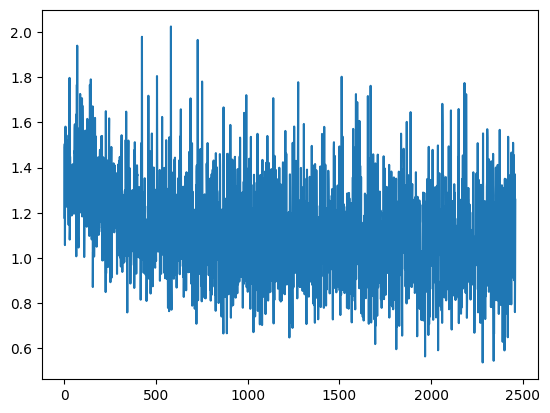

In [19]:
plt.plot(train_losses)

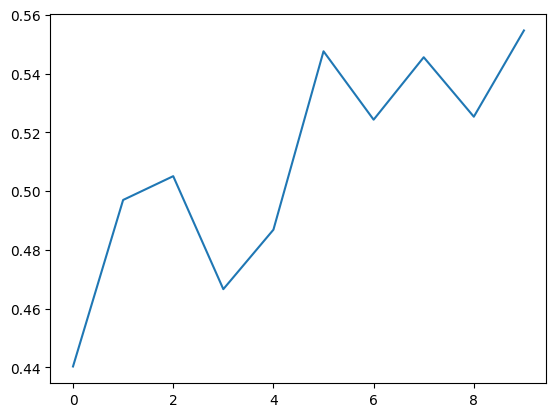

In [20]:
plt.plot(test_accuracy)

In [21]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [22]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 548/976 (0.5615)
{'acc_detail': tensor([0.4480, 0.8373, 0.5327, 0.2562], device='cuda:0'),
 'acc_unweighted': tensor(0.5185, device='cuda:0'),
 'acc_weighted': tensor(0.5615, device='cuda:0'),
 'f1s_detail': tensor([0.5531, 0.6172, 0.5922, 0.3562], device='cuda:0'),
 'f1s_unweighted': tensor(0.5297, device='cuda:0'),
 'f1s_weighted': tensor(0.5429, device='cuda:0'),
 'precision_detail': tensor([0.7226, 0.4888, 0.6667, 0.5843], device='cuda:0'),
 'recall_detail': tensor([0.4480, 0.8373, 0.5327, 0.2562], device='cuda:0'),
 'rocauc': tensor(0.7932, device='cuda:0'),
 'rocauc_detail': tensor([0.7990, 0.7453, 0.8828, 0.7459], device='cuda:0'),
 'uar': tensor(0.5185, device='cuda:0'),
 'wap': tensor(0.6006, device='cuda:0')}


tensor([[ 99,  89,  11,  22],
        [ 11, 283,  32,  12],
        [  3,  94, 114,   3],
        [ 24, 113,  14,  52]], device='cuda:0')

In [23]:
model_path = '../models_iemocap4/iemocap4_m13mfcc_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [24]:
model.to('cpu')

M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=40, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap4_m13mfcc_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_iemocap4/iemocap4_m13mfcc_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)